# Восстановление золота из руды

Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды.

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

План работы:

1. Подготовить данные;
2. Провести исследовательский анализ данных;
3. Построить и обучить модель.

Описание данных

Технологический процесс

Rougher feed — исходное сырье

Rougher additions (или reagent additions) — флотационные реагенты: Xanthate, Sulphate, Depressant 
    
Xanthate **— ксантогенат (промотер, или активатор флотации);

Sulphate — сульфат (на данном производстве сульфид натрия);

Depressant — депрессант (силикат натрия).

Rougher process (англ. «грубый процесс») — флотация

Rougher tails — отвальные хвосты

Float banks — флотационная установка

Cleaner process — очистка

Rougher Au — черновой концентрат золота

Final Au — финальный концентрат золота

Параметры этапов

air amount — объём воздуха

fluid levels — уровень жидкости

feed size — размер гранул сырья

feed rate — скорость подачи

## Подготовка данных

In [1]:
#подключим необходимые библиотеки
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler 
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn import preprocessing
from sklearn.metrics import mean_absolute_error
from numpy.random import RandomState
from scipy import stats as st
import numpy as np
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.dummy import DummyRegressor
import warnings 
warnings.filterwarnings('ignore')
from sklearn.metrics import fbeta_score, make_scorer

In [2]:
#загрузим данные
train_df = pd.read_csv('/datasets/gold_recovery_train_new.csv')
test_df = pd.read_csv('/datasets/gold_recovery_test_new.csv')
full_df = pd.read_csv('/datasets/gold_recovery_full_new.csv')

In [3]:
#посмотрим первые пять строк датасета
train_df.head(5)

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


In [4]:
#посмотрим первые пять строк датасета
test_df.head(5)

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,...,12.033091,-498.350935,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987
4,2016-09-01 04:59:59,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,...,12.025367,-500.786497,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333


In [5]:
#посмотрим первые пять строк датасета
full_df.head(5)

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


In [6]:
#выведим наименования колонок тренировочной выборки
train_df.columns

Index(['date', 'final.output.concentrate_ag', 'final.output.concentrate_pb',
       'final.output.concentrate_sol', 'final.output.concentrate_au',
       'final.output.recovery', 'final.output.tail_ag', 'final.output.tail_pb',
       'final.output.tail_sol', 'final.output.tail_au',
       'primary_cleaner.input.sulfate', 'primary_cleaner.input.depressant',
       'primary_cleaner.input.feed_size', 'primary_cleaner.input.xanthate',
       'primary_cleaner.output.concentrate_ag',
       'primary_cleaner.output.concentrate_pb',
       'primary_cleaner.output.concentrate_sol',
       'primary_cleaner.output.concentrate_au',
       'primary_cleaner.output.tail_ag', 'primary_cleaner.output.tail_pb',
       'primary_cleaner.output.tail_sol', 'primary_cleaner.output.tail_au',
       'primary_cleaner.state.floatbank8_a_air',
       'primary_cleaner.state.floatbank8_a_level',
       'primary_cleaner.state.floatbank8_b_air',
       'primary_cleaner.state.floatbank8_b_level',
       'primary_clean

Проверим, что эффективность обогащения рассчитана правильно. 

Вычислим её на обучающей выборке для признака rougher.output.recovery. 



In [7]:
#обозначим переменные
C=train_df['rougher.output.concentrate_au']
F=train_df['rougher.input.feed_au']
T=train_df['rougher.output.tail_au']

In [8]:
#формула рачета эффективности
recovery=(C*(F-T))/(F*(C-T))*100

In [9]:
recovery.head(5)

0    87.107763
1    86.843261
2    86.842308
3    87.226430
4    86.688794
dtype: float64

Найдем MAE между расчётами и значением признака.

In [10]:
mae=(mean_absolute_error(train_df['rougher.output.recovery'],recovery))

In [11]:
#выведим результат на экран
mae

9.73512347450521e-15

Среднее абсолютное отклонение равно 9.7e-15, в целом погрешность очень маленькая и считать можно расчеты верными.

In [12]:
#посмотрим общую информацию о данных
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14149 non-null  object 
 1   final.output.concentrate_ag                         14148 non-null  float64
 2   final.output.concentrate_pb                         14148 non-null  float64
 3   final.output.concentrate_sol                        13938 non-null  float64
 4   final.output.concentrate_au                         14149 non-null  float64
 5   final.output.recovery                               14149 non-null  float64
 6   final.output.tail_ag                                14149 non-null  float64
 7   final.output.tail_pb                                14049 non-null  float64
 8   final.output.tail_sol                               14144 non-null  float64


In [13]:
#посмотрим общую информацию о данных
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5290 entries, 0 to 5289
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5290 non-null   object 
 1   primary_cleaner.input.sulfate               5286 non-null   float64
 2   primary_cleaner.input.depressant            5285 non-null   float64
 3   primary_cleaner.input.feed_size             5290 non-null   float64
 4   primary_cleaner.input.xanthate              5286 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5290 non-null   float64
 10  primary_clea

In [14]:
#посмотрим общую информацию о данных
full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                19439 non-null  object 
 1   final.output.concentrate_ag                         19438 non-null  float64
 2   final.output.concentrate_pb                         19438 non-null  float64
 3   final.output.concentrate_sol                        19228 non-null  float64
 4   final.output.concentrate_au                         19439 non-null  float64
 5   final.output.recovery                               19439 non-null  float64
 6   final.output.tail_ag                                19438 non-null  float64
 7   final.output.tail_pb                                19338 non-null  float64
 8   final.output.tail_sol                               19433 non-null  float64


In [15]:
#поиск явных дубликатов
train_df.duplicated().sum()

0

In [16]:
#поиск явных дубликатов
test_df.duplicated().sum()

0

In [17]:
#поиск явных дубликатов
full_df.duplicated().sum()

0

Дубликаты отсутствуют во всех датасетах

In [18]:
#посмотрим сколько суммарно имеется прощенных значений по каждому столбцу
train_df.isna().sum()

date                                            0
final.output.concentrate_ag                     1
final.output.concentrate_pb                     1
final.output.concentrate_sol                  211
final.output.concentrate_au                     0
                                             ... 
secondary_cleaner.state.floatbank5_a_level      1
secondary_cleaner.state.floatbank5_b_air        1
secondary_cleaner.state.floatbank5_b_level      1
secondary_cleaner.state.floatbank6_a_air        2
secondary_cleaner.state.floatbank6_a_level      1
Length: 87, dtype: int64

In [19]:
#посмотрим сколько суммарно имеется прощенных значений по каждому столбцу
test_df.isna().sum()

date                                           0
primary_cleaner.input.sulfate                  4
primary_cleaner.input.depressant               5
primary_cleaner.input.feed_size                0
primary_cleaner.input.xanthate                 4
primary_cleaner.state.floatbank8_a_air         0
primary_cleaner.state.floatbank8_a_level       0
primary_cleaner.state.floatbank8_b_air         0
primary_cleaner.state.floatbank8_b_level       0
primary_cleaner.state.floatbank8_c_air         0
primary_cleaner.state.floatbank8_c_level       0
primary_cleaner.state.floatbank8_d_air         0
primary_cleaner.state.floatbank8_d_level       0
rougher.input.feed_ag                          0
rougher.input.feed_pb                          0
rougher.input.feed_rate                        3
rougher.input.feed_size                        1
rougher.input.feed_sol                        21
rougher.input.feed_au                          0
rougher.input.floatbank10_sulfate              5
rougher.input.floatb

In [20]:
#посмотрим сколько суммарно имеется прощенных значений по каждому столбцу
full_df.isna().sum()

date                                            0
final.output.concentrate_ag                     1
final.output.concentrate_pb                     1
final.output.concentrate_sol                  211
final.output.concentrate_au                     0
                                             ... 
secondary_cleaner.state.floatbank5_a_level      1
secondary_cleaner.state.floatbank5_b_air        1
secondary_cleaner.state.floatbank5_b_level      1
secondary_cleaner.state.floatbank6_a_air        2
secondary_cleaner.state.floatbank6_a_level      1
Length: 87, dtype: int64

В каждом датасете имеются пропущенные значения, необходимо провести с ними дальнейшую работу.

In [21]:
#посмотрим на размер таблиц
train_df.shape

(14149, 87)

In [22]:
#посмотрим на размер таблиц
test_df.shape

(5290, 53)

In [23]:
#посмотрим на размер таблиц
full_df.shape

(19439, 87)

В тестовом датасете на 24 столбца меньше

 Проанализируем признаки, недоступные в тестовой выборке.

In [24]:
#посмотрим какие столбцы пропущены
missing_columns=set(full_df)-set(test_df)

In [25]:
missing_columns

{'final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_au',
 'rougher.output.ta

Пропущенные столбцы в тестовой выборке являются параметрами продукта('output') и расчетными характеристиками ('сalculation').



В train есть признаки, которые недоступны в test, потому что из тестовой выборки исключили данные, которые появляются на следующих этапах обработки продукта, а так же данные подсчета, по которым можно посчитать черновой и финальный концентрат по формуле, без использования модели для прогноза. Для достоверного анализа мы убрали часть /этих данных.

In [26]:
train_df=train_df.drop(columns=['date'])

In [27]:
#создадим отдельную таблицу для хранения целевых признаков их исходных данных
full_target=full_df[['date','rougher.output.recovery','final.output.recovery']]

In [28]:
#посмотри размер полученной таблицы
full_target.shape

(19439, 3)

In [29]:
#выведем первые пять значений на экран

full_target.head(5)

,date,rougher.output.recovery,final.output.recovery
0,2016-01-15 00:00:00,87.107763,70.541216
1,2016-01-15 01:00:00,86.843261,69.266198
2,2016-01-15 02:00:00,86.842308,68.116445
3,2016-01-15 03:00:00,87.226430,68.347543
4,2016-01-15 04:00:00,86.688794,66.927016


In [30]:
#добавим к тестовой выборки целевые признаки 'rougher.output.recovery' и 'final.output.recovery', чтобы в дальнейшем мы могли проверить модель
test_df_with_target=pd.merge(test_df,full_target,on=['date'])

In [31]:
#посмотрим на результат
test_df.head(5)

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,...,12.033091,-498.350935,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987
4,2016-09-01 04:59:59,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,...,12.025367,-500.786497,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333


In [32]:
#удалим столбец с датой
test_df=test_df.drop(columns=['date'])
test_df_with_target=test_df_with_target.drop(columns=['date'])
full_df=full_df.drop(columns=['date'])

In [33]:
test_df.head()

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,-500.704369,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,-499.240168,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,-502.151509,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,-498.355873,...,12.033091,-498.350935,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987
4,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,-500.810606,...,12.025367,-500.786497,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333


По условию задачи 'Соседние по времени параметры часто похожи', поэтому заменим пустые значения по ближайшие с помощью KNNImputer

In [34]:
imputer=KNNImputer(n_neighbors=5)
full_df=pd.DataFrame(imputer.fit_transform(full_df),columns=full_df.columns)
full_df.head()

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,123.819808,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,122.270188,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,117.988169,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


In [35]:
imputer=KNNImputer(n_neighbors=5)
test_df=pd.DataFrame(imputer.fit_transform(test_df),columns=test_df.columns)
test_df.head()

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,-500.704369,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,-499.240168,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,-502.151509,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,-498.355873,...,12.033091,-498.350935,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987
4,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,-500.810606,...,12.025367,-500.786497,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333


In [36]:
imputer=KNNImputer(n_neighbors=5)
train_df=pd.DataFrame(imputer.fit_transform(train_df),columns=train_df.columns)
train_df.head()

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,123.819808,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,122.270188,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,117.988169,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


In [37]:
#посмотрим изменения
test_df.isna().sum()

primary_cleaner.input.sulfate                 0
primary_cleaner.input.depressant              0
primary_cleaner.input.feed_size               0
primary_cleaner.input.xanthate                0
primary_cleaner.state.floatbank8_a_air        0
primary_cleaner.state.floatbank8_a_level      0
primary_cleaner.state.floatbank8_b_air        0
primary_cleaner.state.floatbank8_b_level      0
primary_cleaner.state.floatbank8_c_air        0
primary_cleaner.state.floatbank8_c_level      0
primary_cleaner.state.floatbank8_d_air        0
primary_cleaner.state.floatbank8_d_level      0
rougher.input.feed_ag                         0
rougher.input.feed_pb                         0
rougher.input.feed_rate                       0
rougher.input.feed_size                       0
rougher.input.feed_sol                        0
rougher.input.feed_au                         0
rougher.input.floatbank10_sulfate             0
rougher.input.floatbank10_xanthate            0
rougher.input.floatbank11_sulfate       

In [38]:
#посмотрим изменения
train_df.isna().sum()

final.output.concentrate_ag                   0
final.output.concentrate_pb                   0
final.output.concentrate_sol                  0
final.output.concentrate_au                   0
final.output.recovery                         0
                                             ..
secondary_cleaner.state.floatbank5_a_level    0
secondary_cleaner.state.floatbank5_b_air      0
secondary_cleaner.state.floatbank5_b_level    0
secondary_cleaner.state.floatbank6_a_air      0
secondary_cleaner.state.floatbank6_a_level    0
Length: 86, dtype: int64

Пропущенных значений нет

Вывод:

Данные находятся в трёх файлах:

gold_recovery_train_new.csv — обучающая выборка;

gold_recovery_test_new.csv — тестовая выборка;

gold_recovery_full_new.csv — исходные данные.

Расчитан MAE. Среднее абсолютное отклонение равно 9.7e-15, в целом погрешность очень маленькая и считать можно расчеты верными.

Проведен анализ недостающих столбцов в тестовой выборке. Пропущенные столбцы в тестовой выборке являются параметрами продукта('output') и расчетными характеристиками ('сalculation').

Удален столбец data, так как далее нам понадобяться числовые данные

Форматы данных корректные.

Пропуски в данных заменены соседними значениями с помощью KNNImputer.

Явных дубликатов не имеется.

## Анализ данных

2.1. Посмотрим, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки

In [39]:
full_df.columns

Index(['final.output.concentrate_ag', 'final.output.concentrate_pb',
       'final.output.concentrate_sol', 'final.output.concentrate_au',
       'final.output.recovery', 'final.output.tail_ag', 'final.output.tail_pb',
       'final.output.tail_sol', 'final.output.tail_au',
       'primary_cleaner.input.sulfate', 'primary_cleaner.input.depressant',
       'primary_cleaner.input.feed_size', 'primary_cleaner.input.xanthate',
       'primary_cleaner.output.concentrate_ag',
       'primary_cleaner.output.concentrate_pb',
       'primary_cleaner.output.concentrate_sol',
       'primary_cleaner.output.concentrate_au',
       'primary_cleaner.output.tail_ag', 'primary_cleaner.output.tail_pb',
       'primary_cleaner.output.tail_sol', 'primary_cleaner.output.tail_au',
       'primary_cleaner.state.floatbank8_a_air',
       'primary_cleaner.state.floatbank8_a_level',
       'primary_cleaner.state.floatbank8_b_air',
       'primary_cleaner.state.floatbank8_b_level',
       'primary_cleaner.state

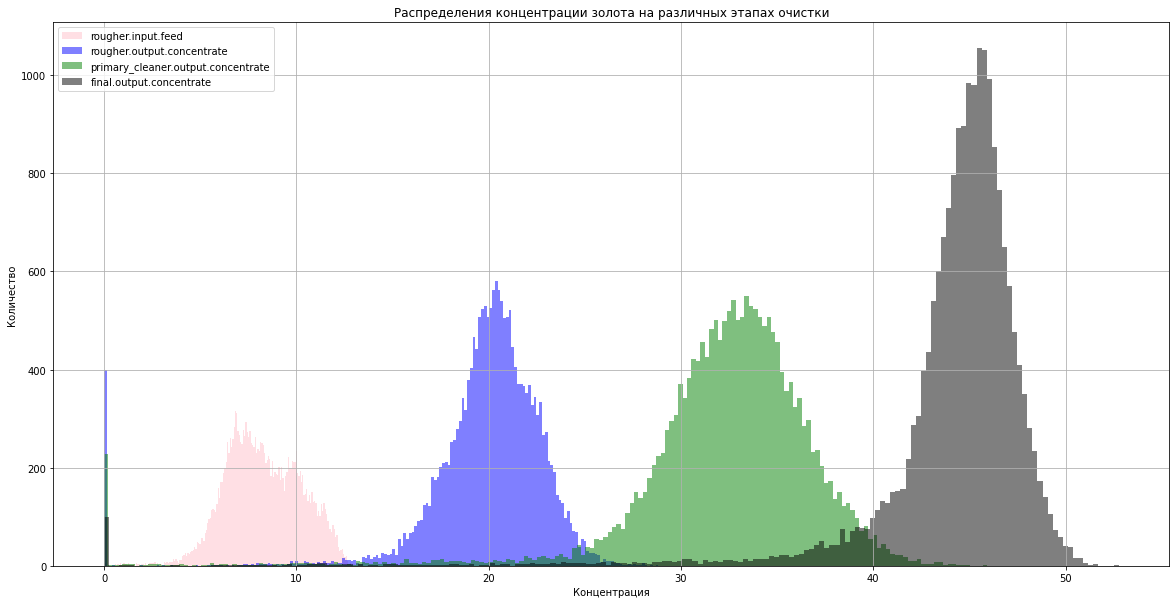

In [40]:
#построим гистограмму распределения концентрации золота на различных этапах очистки
plt.figure(figsize=(20,10))
full_df['rougher.input.feed_au'].hist(bins=200, color='pink',label='rougher.input.feed',alpha=0.5)
full_df['rougher.output.concentrate_au'].hist(bins=200, color='blue',label='rougher.output.concentrate',alpha=0.5)
full_df['primary_cleaner.output.concentrate_au'].hist(bins=200, color='green',label='primary_cleaner.output.concentrate',alpha=0.5)
full_df['final.output.concentrate_au'].hist(bins=200, color='black',label='final.output.concentrate',alpha=0.5)
plt.legend()
plt.title('Распределения концентрации золота на различных этапах очистки')
plt.xlabel('Концентрация')
plt.ylabel('Количество')
plt.show()


Концентрация золота увеличивается с каждым этапом очистки, на этапе флотации и первичной обработки - примерно одинаковая,на финальном этапе - концентрации наибольшая.

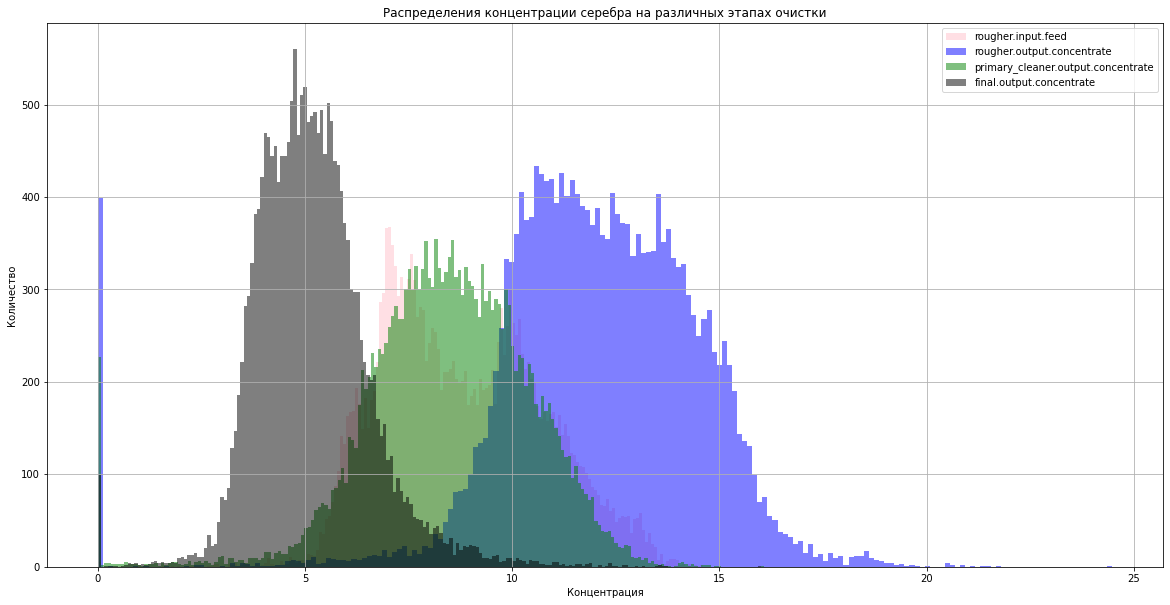

In [41]:
#построим гистограмму распределения концентрации серебра на различных этапах очистки
plt.figure(figsize=(20,10))
full_df['rougher.input.feed_ag'].hist(bins=200, color='pink',label='rougher.input.feed',alpha=0.5)
full_df['rougher.output.concentrate_ag'].hist(bins=200, color='blue',label='rougher.output.concentrate',alpha=0.5)
full_df['primary_cleaner.output.concentrate_ag'].hist(bins=200, color='green',label='primary_cleaner.output.concentrate',alpha=0.5)
full_df['final.output.concentrate_ag'].hist(bins=200, color='black',label='final.output.concentrate',alpha=0.5)
plt.legend()
plt.title('Распределения концентрации серебра на различных этапах очистки')
plt.xlabel('Концентрация')
plt.ylabel('Количество')
plt.show()



Концентрация серебра увеличивается с каждым этапом очистки, на этапе флотации и первичной обработки - примерно одинаковая,на финальном этапе - концентрации наибольшая.

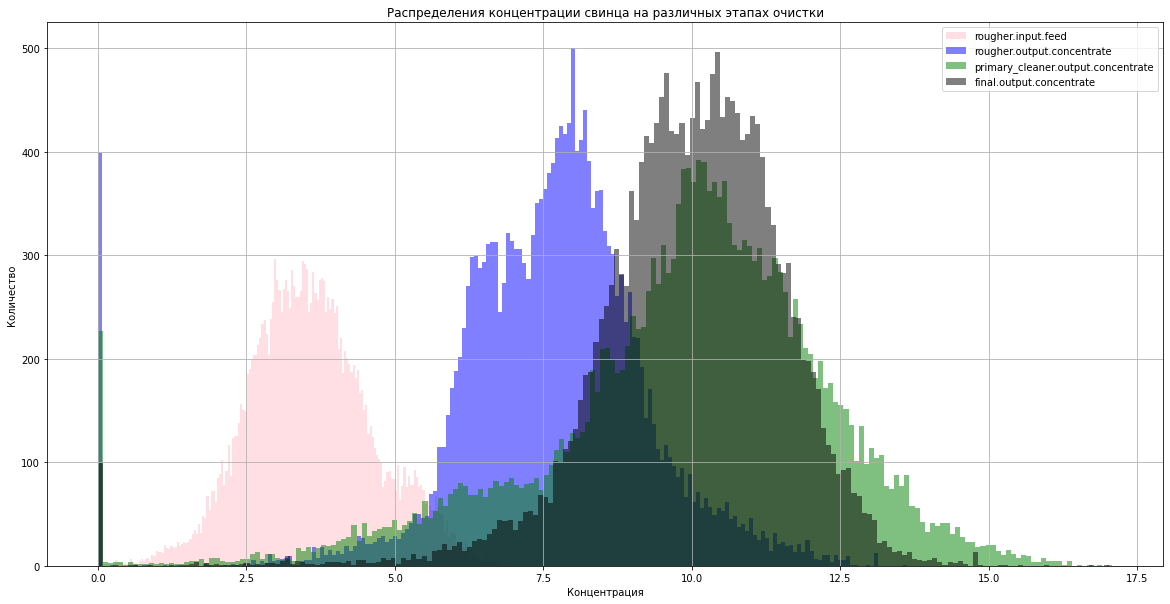

In [42]:
#построим гистограмму распределения концентрации свинца на различных этапах очистки
plt.figure(figsize=(20,10))
full_df['rougher.input.feed_pb'].hist(bins=200, color='pink',label='rougher.input.feed',alpha=0.5)
full_df['rougher.output.concentrate_pb'].hist(bins=200, color='blue',label='rougher.output.concentrate',alpha=0.5)
full_df['primary_cleaner.output.concentrate_pb'].hist(bins=200, color='green',label='primary_cleaner.output.concentrate',alpha=0.5)
full_df['final.output.concentrate_pb'].hist(bins=200, color='black',label='final.output.concentrate',alpha=0.5)
plt.legend()
plt.title('Распределения концентрации свинца на различных этапах очистки')
plt.xlabel('Концентрация')
plt.ylabel('Количество')
plt.show()



Концентрация свинца увеличивается с каждым этапом очистки, на этапе флотации и первичной обработки - примерно одинаковая,на финальном этапе - концентрации наибольшая.

Вывод

По графикам мы видим, что концентрация металлов(золота,серебра и свинца) увеличивается с каждым этапом очистки.

2.2.  Сравним распределения размеров гранул сырья на обучающей и тестовой выборках. Если распределения сильно отличаются друг от друга, оценка модели будет неправильной.


In [43]:
train_df['rougher.input.feed_size']
test_df['rougher.input.feed_size']

0       62.710452
1       61.961163
2       66.903807
3       59.865919
4       63.315324
          ...    
5285    66.758479
5286    62.560684
5287    73.647513
5288    78.066446
5289    77.678700
Name: rougher.input.feed_size, Length: 5290, dtype: float64

In [44]:
train_df['primary_cleaner.input.feed_size']
test_df['primary_cleaner.input.feed_size']

0       8.080000
1       8.080000
2       7.786667
3       7.640000
4       7.530000
          ...   
5285    8.070000
5286    8.070000
5287    8.070000
5288    8.070000
5289    8.070000
Name: primary_cleaner.input.feed_size, Length: 5290, dtype: float64

Рассмотрим распределения размеров гранул сырья на этапе флотации сырья (rougher.input)

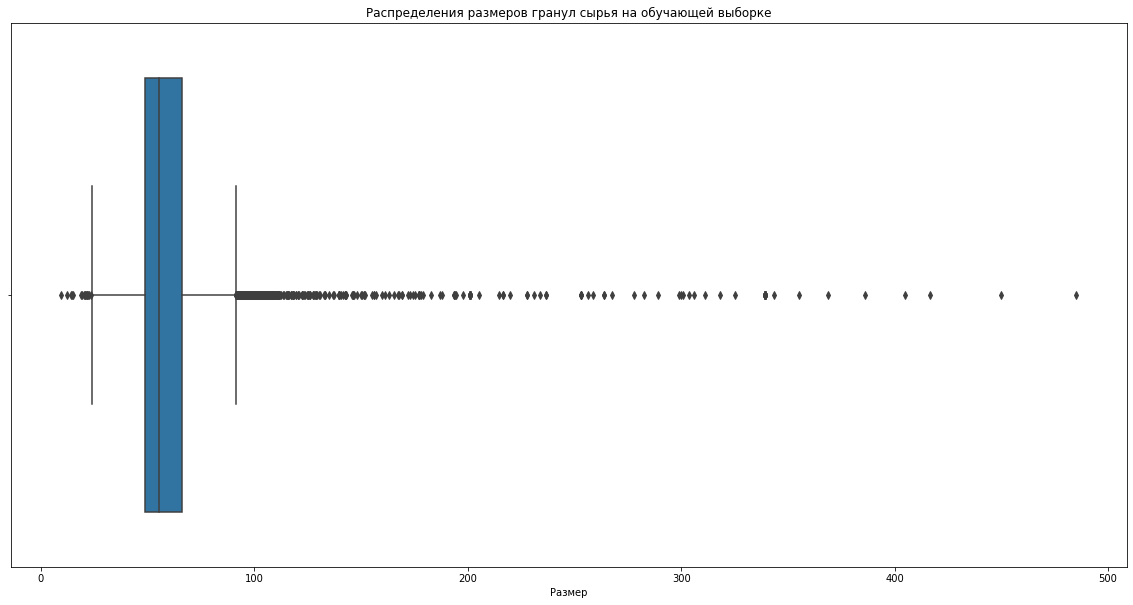

In [45]:
plt.figure(figsize=(20,10))
sns.boxplot(data=train_df, x='rougher.input.feed_size')
plt.title('Распределения размеров гранул сырья на обучающей выборке')
plt.xlabel('Размер')
plt.show()

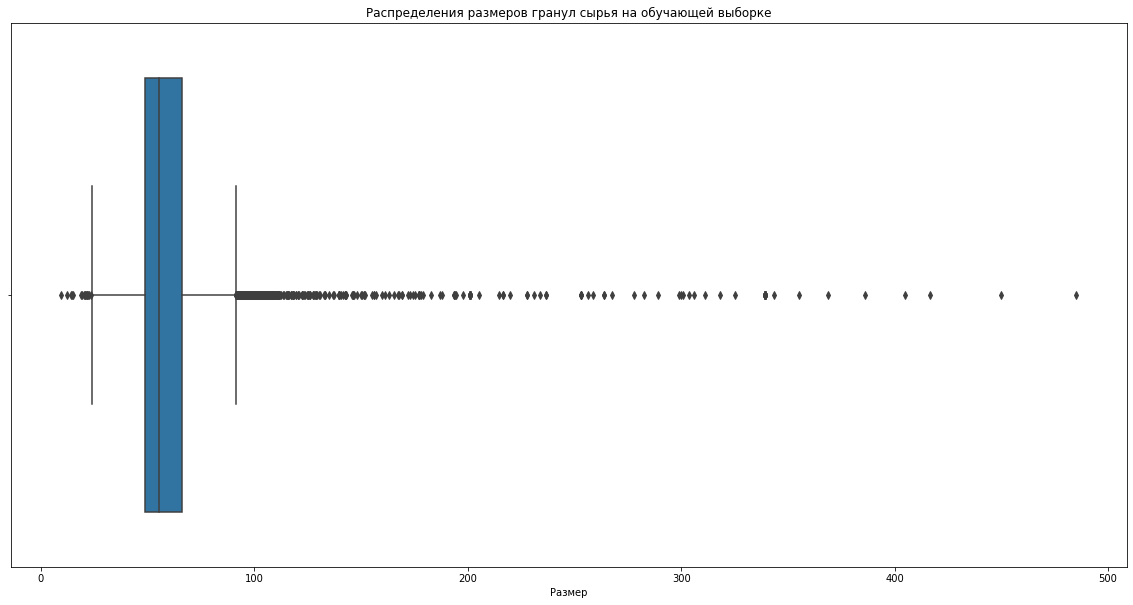

In [46]:
plt.figure(figsize=(20,10))
sns.boxplot(data=train_df, x='rougher.input.feed_size')
plt.title('Распределения размеров гранул сырья на обучающей выборке')
plt.xlabel('Размер')
plt.show()

Рассмотрим распределения размеров гранул сырья на этапе первичной обработки сырья (primary_cleaner.input)

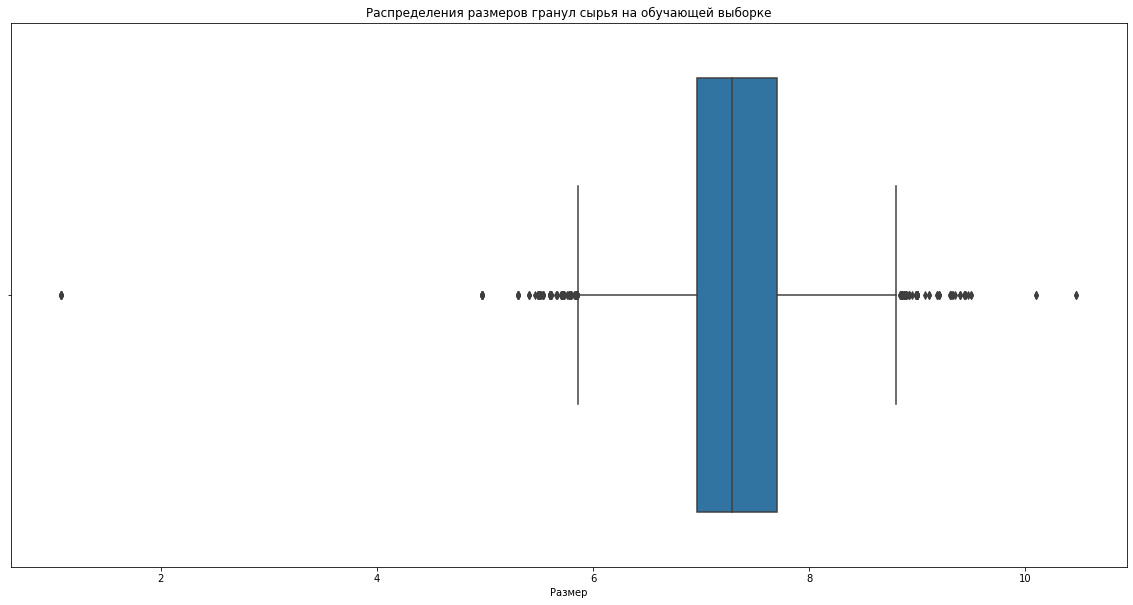

In [47]:
plt.figure(figsize=(20,10))
sns.boxplot(data=train_df, x='primary_cleaner.input.feed_size')
plt.title('Распределения размеров гранул сырья на обучающей выборке')
plt.xlabel('Размер')
plt.show()

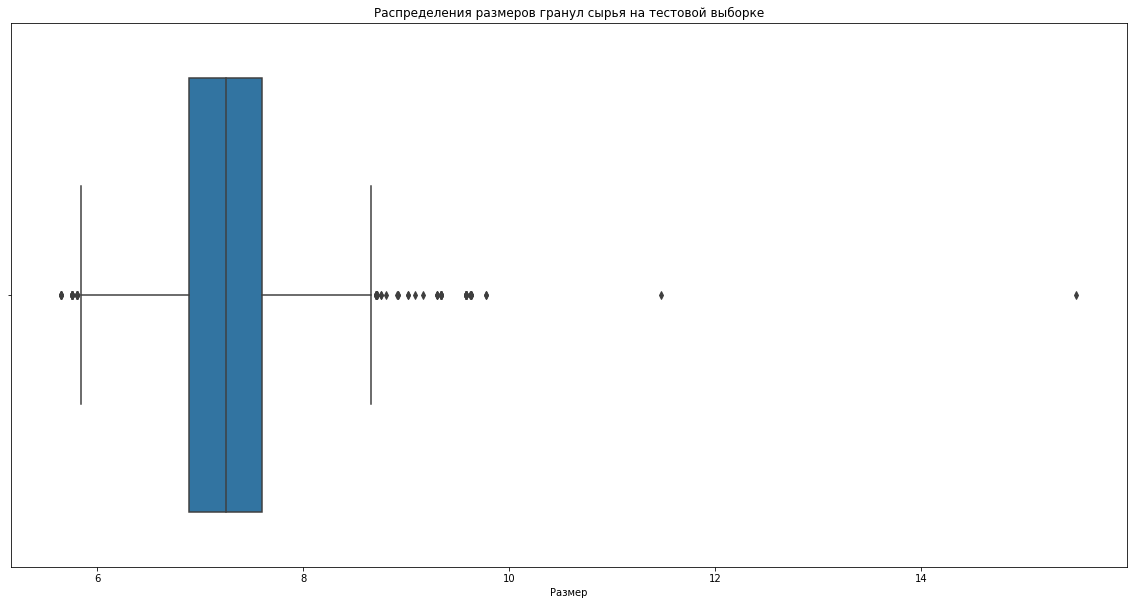

In [48]:
plt.figure(figsize=(20,10))
sns.boxplot(data=test_df, x='primary_cleaner.input.feed_size')
plt.title('Распределения размеров гранул сырья на тестовой выборке')
plt.xlabel('Размер')
plt.show()

По графикам распределения гранул сырья на обучающей и тестовой выборках мы видим, что они похожи и не отличаются друг от друга. Это значит, что оценка модели в дальнейшем будет правильной.

2.3. Исследуем суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах. 

input — параметры сырья
Rougher  — черновой концентрат 
Final  — финальный концентрат 

In [49]:
train_df.columns

Index(['final.output.concentrate_ag', 'final.output.concentrate_pb',
       'final.output.concentrate_sol', 'final.output.concentrate_au',
       'final.output.recovery', 'final.output.tail_ag', 'final.output.tail_pb',
       'final.output.tail_sol', 'final.output.tail_au',
       'primary_cleaner.input.sulfate', 'primary_cleaner.input.depressant',
       'primary_cleaner.input.feed_size', 'primary_cleaner.input.xanthate',
       'primary_cleaner.output.concentrate_ag',
       'primary_cleaner.output.concentrate_pb',
       'primary_cleaner.output.concentrate_sol',
       'primary_cleaner.output.concentrate_au',
       'primary_cleaner.output.tail_ag', 'primary_cleaner.output.tail_pb',
       'primary_cleaner.output.tail_sol', 'primary_cleaner.output.tail_au',
       'primary_cleaner.state.floatbank8_a_air',
       'primary_cleaner.state.floatbank8_a_level',
       'primary_cleaner.state.floatbank8_b_air',
       'primary_cleaner.state.floatbank8_b_level',
       'primary_cleaner.state

In [50]:
#суммируем данные по этапу флотация сырья
train_df['rougher_input']=train_df[['rougher.input.feed_pb','rougher.input.feed_ag','rougher.input.feed_sol','rougher.input.feed_au']].sum(axis=1)

In [51]:
train_df['rougher_ouput']=train_df[['rougher.output.concentrate_ag','rougher.output.concentrate_pb','rougher.output.concentrate_sol','rougher.output.concentrate_au']].sum(axis=1)

In [52]:
#суммируем данные по этапу флотация продукта
train_df['rougher_output_sum']=train_df[['rougher.output.concentrate_ag','rougher.output.concentrate_pb','rougher.output.concentrate_sol','rougher.output.concentrate_au']].sum(axis=1)

In [53]:
#суммируем данные по этапу первичная обработка продукта
train_df['primary_cleaner_output']=train_df[['primary_cleaner.output.concentrate_ag','primary_cleaner.output.concentrate_pb','primary_cleaner.output.concentrate_sol','primary_cleaner.output.concentrate_au']].sum(axis=1)

In [54]:
#суммируем данные по этапу финальная обработка продукта
train_df['final_output']=train_df[['final.output.concentrate_ag', 'final.output.concentrate_pb',
       'final.output.concentrate_sol', 'final.output.concentrate_au']].sum(axis=1)
train_df.head()

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level,rougher_input,rougher_ouput,rougher_output_sum,primary_cleaner_output,final_output
0,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,...,-498.310211,8.079666,-500.470978,14.151341,-605.841980,51.680034,66.424950,66.424950,72.640924,63.644396
1,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,...,-500.169983,7.984757,-500.582168,13.998353,-599.787184,50.659114,67.012710,67.012710,72.543485,63.957723
2,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,123.819808,...,-500.129135,8.013877,-500.517572,14.028663,-601.427363,50.609929,66.103793,66.103793,72.095042,64.311180
3,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,122.270188,...,-499.201640,7.977324,-500.255908,14.005551,-599.996129,51.061546,65.752751,65.752751,59.957723,63.573449
4,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,117.988169,...,-501.686727,7.894242,-500.356035,13.996647,-601.496691,47.859163,65.908382,65.908382,71.321010,64.004667


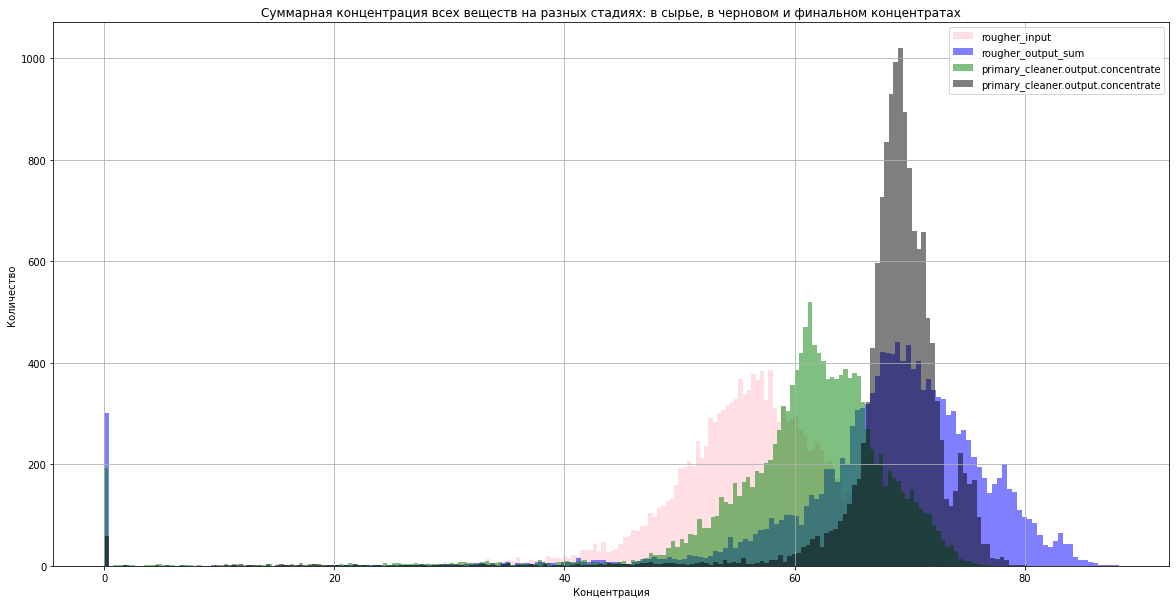

In [55]:
plt.figure(figsize=(20,10))
train_df['rougher_input'].hist(bins=200, color='pink',label='rougher_input',alpha=0.5)
train_df['rougher_output_sum'].hist(bins=200, color='blue',label='rougher_output_sum',alpha=0.5)
train_df['primary_cleaner_output'].hist(bins=200, color='green',label='primary_cleaner.output.concentrate',alpha=0.5)
train_df['final_output'].hist(bins=200, color='black',label='primary_cleaner.output.concentrate',alpha=0.5)
plt.legend()
plt.title('Суммарная концентрация всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах')
plt.xlabel('Концентрация')
plt.ylabel('Количество')
plt.show()

По графикам мы видим общую закономерность - на последних трех этапах очистки имеются аномальные минимальные значения, то есть проведение обработки дало минимальную концентрацию металлов.
Исходя из этого, принимаем решение удалить минимальные значения.

In [56]:
train_df=train_df.drop(train_df[train_df['rougher_input']<=1].index)
train_df=train_df.drop(train_df[train_df['rougher_output_sum']<=1].index)
train_df=train_df.drop(train_df[train_df['primary_cleaner_output']<=1].index)
train_df=train_df.drop(train_df[train_df['final_output']<=1].index)

In [57]:
#из тренировочной выборки удалим пропущенные столбцы, которых нет в тестовой выборки, кроме целевых прихнаков 'rougher.output.recovery' и 'final.output.recovery'
train_df=train_df.drop(columns=['rougher_input','rougher_ouput','rougher_output_sum','primary_cleaner_output','final_output','final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.tail_ag',
 'rougher.output.tail_au',
 'rougher.output.tail_pb',
 'rougher.output.tail_sol',
 'secondary_cleaner.output.tail_ag',
 'secondary_cleaner.output.tail_au',
 'secondary_cleaner.output.tail_pb',
 'secondary_cleaner.output.tail_sol'])

Вывод 

Мы посмотрели на графиках как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки. Концентрация золота увеличивается с каждым этапом очистки. Концентрация серебра увеличивается до этапа флотации продукта, а далее снижается. Концентрация серебра увеличивается до этапа первичной очистки продукта, а далее снижается.

Сравнили распределения по диаграммам рахмаха размеры гранул сырья на обучающей и тестовой выборках. Они похожи и не отличаются друг от друга (имеют схожую медиану и аномальные выбросы на одинаковой удаленности). Это значит, что оценка модели в дальнейшем будет правильной.

Исследовали суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах. Обнаружили аномалии и удалили их.

## Модель

Напишем функцию для вычисления итоговой sMAPE.

Для решения задачи введём новую метрику качества — sMAPE (англ. Symmetric Mean Absolute Percentage Error, «симметричное среднее абсолютное процентное отклонение»).
Она похожа на MAE, но выражается не в абсолютных величинах, а в относительных. 

In [58]:
#создадим функцию для расчета SMAPE
def smape(A, B):
    return 1/len(A) * np.sum(2 * np.abs(B - A) / (np.abs(A) + np.abs(B)))*100

In [59]:
#создадим функцию для расчета итогового SMAPE
def smape_fin(smape_rougher,smape_finel):
    return 0.25*smape_rougher+0.75*smape_finel

In [60]:
#разделим тренировочный датасет на признаки и целевые признаки
features_1=train_df.drop(['rougher.output.recovery','final.output.recovery'], axis=1)
target_1=train_df['rougher.output.recovery']
target_2=train_df['final.output.recovery']

Построим модели для целевого признака 'эффективность обогащения чернового концентрата'

In [61]:
#обучим модель линейной регрессии
model = LinearRegression()
scorer = make_scorer(smape, greater_is_better=False)
scores=cross_val_score(model, features_1, target_1, cv=3, scoring=scorer,n_jobs=-1,verbose=10)
final_score_rougher_lr=scores.mean()
print('sMAPE модели линейной регрессии:', -final_score_rougher_lr)

[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] START .....................................................................
[CV] END ............................... score: (test=-9.387) total time=   0.1s
[CV] START .....................................................................
[CV] END ............................... score: (test=-8.250) total time=   0.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s


[CV] END .............................. score: (test=-12.962) total time=   0.2s
sMAPE модели линейной регрессии: 10.19971961297467


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.8s finished


In [62]:
#обучим модель дерева решений
#найдем наилучшую модели
best_model = None
best_result_dtr_rougher = 100
best_depth = 0
for depth in range(1, 20, 2):
    model_2=DecisionTreeRegressor(random_state = 12345,max_depth=depth)
    scorer = make_scorer(smape, greater_is_better=False)
    scores=abs(cross_val_score(model_2, features_1, target_1, cv=3,scoring=scorer,n_jobs=-1,verbose=10).mean())
    if scores < best_result_dtr_rougher:
        best_model = model_2
        best_result_dtr_rougher = scores
        best_depth = depth
print("sMAPE наилучшей модели:", best_result_dtr_rougher)
print("Глубина:", best_depth)

[CV] START .....................................................................
[CV] END .............................. score: (test=-10.940) total time=   0.1s


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s


[CV] START .....................................................................
[CV] END ............................... score: (test=-7.815) total time=   0.1s
[CV] START .....................................................................
[CV] END ............................... score: (test=-9.874) total time=   0.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-9.275) total time=   0.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV] END ............................... score: (test=-7.739) total time=   0.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s


[CV] END ............................... score: (test=-8.080) total time=   0.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-9.268) total time=   0.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV] END ............................... score: (test=-8.602) total time=   0.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s


[CV] END ............................... score: (test=-8.636) total time=   0.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-9.189) total time=   0.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV] END ............................... score: (test=-8.296) total time=   0.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s


[CV] END ............................... score: (test=-9.432) total time=   0.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-9.255) total time=   0.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV] END ............................... score: (test=-9.290) total time=   0.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.8s remaining:    0.0s


[CV] END .............................. score: (test=-10.153) total time=   0.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.2s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-9.518) total time=   0.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV] END ............................... score: (test=-8.463) total time=   0.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    1.0s remaining:    0.0s


[CV] END .............................. score: (test=-11.084) total time=   0.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.4s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-9.718) total time=   0.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV] END ............................... score: (test=-8.546) total time=   0.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    1.1s remaining:    0.0s


[CV] END ............................... score: (test=-9.757) total time=   0.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.6s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-9.966) total time=   0.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV] END .............................. score: (test=-10.417) total time=   0.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    1.2s remaining:    0.0s


[CV] END .............................. score: (test=-10.154) total time=   0.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.7s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-9.832) total time=   0.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV] END .............................. score: (test=-10.251) total time=   0.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    1.2s remaining:    0.0s


[CV] END .............................. score: (test=-10.197) total time=   0.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.8s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.082) total time=   0.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV] END ............................... score: (test=-8.994) total time=   0.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    1.3s remaining:    0.0s


[CV] END .............................. score: (test=-10.265) total time=   0.7s
sMAPE наилучшей модели: 8.364717080280462
Глубина: 3


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.9s finished


In [63]:
best_model = None
best_depth = 0
best_est = 0
best_result_rfr_routher = 100
for est in range(10, 51, 10):
    for depth in range(1, 20, 10):
        model_3_rougher = RandomForestRegressor(random_state=12345, n_estimators=est, max_depth=depth)
        scorer = make_scorer(smape, greater_is_better=False)
        scores=abs(cross_val_score(model_3_rougher, features_1, target_1, cv=3,scoring=scorer,n_jobs=-1,verbose=10).mean())
        if scores < best_result_rfr_routher:
            best_model = model_2
            best_result_rfr_routher = scores
            best_depth = depth
            best_est = est        

print("sMAPE наилучшей модели:", best_result_rfr_routher)
print("Глубина", best_depth)
print("Количество оценщиков", best_est)  

[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.542) total time=   0.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV] END ............................... score: (test=-7.832) total time=   0.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.8s remaining:    0.0s


[CV] END ............................... score: (test=-9.445) total time=   0.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.2s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-8.083) total time=   2.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.9s remaining:    0.0s


[CV] END ............................... score: (test=-7.109) total time=   2.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    5.8s remaining:    0.0s


[CV] END ............................... score: (test=-9.521) total time=   2.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    8.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    8.6s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.613) total time=   0.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s


[CV] END ............................... score: (test=-7.824) total time=   0.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    1.4s remaining:    0.0s


[CV] END ............................... score: (test=-9.529) total time=   0.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.1s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-8.178) total time=   6.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    6.1s remaining:    0.0s


[CV] END ............................... score: (test=-7.050) total time=   5.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   11.5s remaining:    0.0s


[CV] END ............................... score: (test=-9.589) total time=   5.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   17.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   17.1s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.677) total time=   1.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s


[CV] END ............................... score: (test=-7.822) total time=   1.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    2.1s remaining:    0.0s


[CV] END ............................... score: (test=-9.585) total time=   1.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.1s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-8.011) total time=   8.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    8.4s remaining:    0.0s


[CV] END ............................... score: (test=-7.100) total time=   8.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   16.7s remaining:    0.0s


[CV] END ............................... score: (test=-9.594) total time=   8.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   24.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   24.8s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.713) total time=   1.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.3s remaining:    0.0s


[CV] END ............................... score: (test=-7.834) total time=   1.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    2.7s remaining:    0.0s


[CV] END ............................... score: (test=-9.586) total time=   1.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-8.087) total time=  11.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   11.9s remaining:    0.0s


[CV] END ............................... score: (test=-7.132) total time=  11.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   23.7s remaining:    0.0s


[CV] END ............................... score: (test=-9.414) total time=  11.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   35.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   35.6s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.760) total time=   2.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.0s remaining:    0.0s


[CV] END ............................... score: (test=-7.831) total time=   2.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    4.0s remaining:    0.0s


[CV] END ............................... score: (test=-9.598) total time=   1.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.9s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-8.139) total time=  15.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   15.3s remaining:    0.0s


[CV] END ............................... score: (test=-6.984) total time=  14.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   29.3s remaining:    0.0s


[CV] END ............................... score: (test=-9.511) total time=  14.8s
sMAPE наилучшей модели: 8.210801252425227
Глубина 11
Количество оценщиков 40


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   44.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   44.1s finished


Вопрос 

Зачем счетчик make_scorer при выборе функции потерь (greater_is_better=False) меняет знак на противоположный?

Построены три модели для целевого признака 'эффективность обогащения чернового концентрата' - линейная регрессия, дерево решений и случайный лес. Наилучший результат дала модель - случайного леса

Построим модели для целевого признака 'эффективность обогащения финального концентрата'

In [64]:
#обучим модель линейной регрессии
model = LinearRegression() 
scorer = make_scorer(smape, greater_is_better=False)
scores=cross_val_score(model, features_1, target_2, cv=3,scoring=scorer,n_jobs=-1,verbose=10)
final_score_final_lr=scores.mean()
print('sMAPE модели линейной регрессии:', -final_score_final_lr)

[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-12.508) total time=   0.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s


[CV] END .............................. score: (test=-12.756) total time=   0.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    1.1s remaining:    0.0s


[CV] END .............................. score: (test=-16.313) total time=   0.5s
sMAPE модели линейной регрессии: 13.859093251181731


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.7s finished


In [65]:
#расчитаем итоговый sMAPE для линейной регрессии
final_smape_lr=smape_fin(final_score_rougher_lr,final_score_final_lr)
print("Итоговый sMAPE для линейной регрессии ", -final_smape_lr)

Итоговый sMAPE для линейной регрессии  12.944249841629965


In [66]:
#обучим модель дерева решений
#найдем наилучшую модели
best_model = None
best_result_dtr_finel = 100
best_depth = 0
for depth in range(1, 20, 2):
    model_2=DecisionTreeRegressor(random_state = 12345,max_depth=depth)
    scorer = make_scorer(smape, greater_is_better=False)
    scores=abs(cross_val_score(model_2, features_1, target_2, cv=3,scoring=scorer,n_jobs=-1,verbose=10).mean())
    if scores < best_result_dtr_finel:
        best_model = model_2
        best_result_dtr_finel = scores
        best_depth = depth
print("Глубина:", best_depth)
print("sMAPE модели дерева решений:", best_result_dtr_finel)


[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] END ............................... score: (test=-9.311) total time=   0.1s
[CV] START .....................................................................
[CV] END .............................. score: (test=-10.043) total time=   0.1s
[CV] START .....................................................................
[CV] END .............................. score: (test=-11.131) total time=   0.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-9.273) total time=   0.2s
[CV] START .....................................................................
[CV] END .............................. score: (test=-10.319) total time=   0.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s


[CV] END .............................. score: (test=-13.480) total time=   0.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-9.960) total time=   0.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV] END .............................. score: (test=-11.056) total time=   0.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s


[CV] END .............................. score: (test=-13.224) total time=   0.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.339) total time=   0.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV] END .............................. score: (test=-11.853) total time=   0.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.7s remaining:    0.0s


[CV] END .............................. score: (test=-12.591) total time=   0.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.1s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-12.067) total time=   0.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV] END .............................. score: (test=-12.675) total time=   0.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.9s remaining:    0.0s


[CV] END .............................. score: (test=-12.615) total time=   0.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.3s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-12.902) total time=   0.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV] END .............................. score: (test=-14.876) total time=   0.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    1.0s remaining:    0.0s


[CV] END .............................. score: (test=-14.308) total time=   0.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.5s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-13.503) total time=   0.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV] END .............................. score: (test=-16.078) total time=   0.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    1.2s remaining:    0.0s


[CV] END .............................. score: (test=-14.739) total time=   0.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.8s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-16.562) total time=   0.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s


[CV] END .............................. score: (test=-16.195) total time=   0.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    1.3s remaining:    0.0s


[CV] END .............................. score: (test=-14.066) total time=   0.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.9s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-16.700) total time=   0.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s


[CV] END .............................. score: (test=-15.397) total time=   0.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    1.4s remaining:    0.0s


[CV] END .............................. score: (test=-15.289) total time=   0.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.1s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-14.478) total time=   0.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s


[CV] END .............................. score: (test=-16.150) total time=   0.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    1.4s remaining:    0.0s


[CV] END .............................. score: (test=-15.599) total time=   0.7s
Глубина: 1
sMAPE модели дерева решений: 10.161494417865852


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.2s finished


In [67]:
#расчитаем итоговый sMAPE для дерева решений
final_smape_dtr=smape_fin(best_result_dtr_rougher,best_result_dtr_finel)
print("Итоговый sMAPE для дерева решений ", final_smape_dtr)

Итоговый sMAPE для дерева решений  9.712300083469504


In [82]:
best_model = None
best_result_rfr_finel = 100
best_depth = 0
best_est = 0
for est in range(10, 51, 10):
    for depth in range(1, 20, 10):
        model_3 = RandomForestRegressor(random_state=12345, n_estimators=est, max_depth=depth)
        scorer = make_scorer(smape, greater_is_better=False)
        scores=abs(cross_val_score(model_3, features_1, target_2, cv=3,scoring=scorer,n_jobs=-1,verbose=10).mean())
        if scores < best_result_rfr_finel:
            best_model = model_2
            best_result_rfr_finel = scores
            best_depth = depth
            best_est = est
print("sMAPE наилучшей модели случайного леса:", best_result_rfr_finel)
print("Глубина", best_depth)
print("Количество оценщиков",  best_est)  

[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] START .....................................................................
[CV] END ............................... score: (test=-9.306) total time=   0.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV] END ............................... score: (test=-9.503) total time=   0.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.7s remaining:    0.0s


[CV] END .............................. score: (test=-11.144) total time=   0.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.1s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-9.999) total time=   2.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.9s remaining:    0.0s


[CV] END .............................. score: (test=-10.069) total time=   2.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    5.8s remaining:    0.0s


[CV] END .............................. score: (test=-12.088) total time=   2.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    8.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    8.7s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-9.300) total time=   0.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s


[CV] END ............................... score: (test=-9.496) total time=   0.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    1.4s remaining:    0.0s


[CV] END .............................. score: (test=-11.123) total time=   0.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.1s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-9.978) total time=   5.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    5.8s remaining:    0.0s


[CV] END ............................... score: (test=-9.565) total time=   5.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   11.4s remaining:    0.0s


[CV] END .............................. score: (test=-11.892) total time=   5.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   17.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   17.1s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-9.283) total time=   0.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s


[CV] END ............................... score: (test=-9.366) total time=   1.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    1.9s remaining:    0.0s


[CV] END .............................. score: (test=-11.131) total time=   1.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-9.857) total time=   8.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    8.8s remaining:    0.0s


[CV] END ............................... score: (test=-9.617) total time=   8.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   17.0s remaining:    0.0s


[CV] END .............................. score: (test=-12.084) total time=   8.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   25.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   25.9s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-9.286) total time=   1.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.3s remaining:    0.0s


[CV] END ............................... score: (test=-9.293) total time=   1.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    2.7s remaining:    0.0s


[CV] END .............................. score: (test=-11.122) total time=   1.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-9.843) total time=  11.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   11.4s remaining:    0.0s


[CV] END ............................... score: (test=-9.335) total time=  10.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   22.3s remaining:    0.0s


[CV] END .............................. score: (test=-12.166) total time=  11.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   33.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   33.9s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-9.281) total time=   1.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s


[CV] END ............................... score: (test=-9.317) total time=   1.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    3.3s remaining:    0.0s


[CV] END .............................. score: (test=-11.117) total time=   1.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-9.870) total time=  13.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   13.7s remaining:    0.0s


[CV] END ............................... score: (test=-9.354) total time=  13.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   27.6s remaining:    0.0s


[CV] END .............................. score: (test=-12.184) total time=  14.1s
sMAPE наилучшей модели случайного леса: 9.900516551096478
Глубина 1
Количество оценщиков 40


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   41.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   41.7s finished


In [83]:
#расчитаем итоговый sMAPE для случайного леса
final_smape_dtr=smape_fin(best_result_rfr_routher,best_result_rfr_finel)
print("Итоговый sMAPE для случайного леса", final_smape_dtr)

Итоговый sMAPE для случайного леса 9.478087726428665


Построены три модели для целевого признака 'эффективность обогащения финального концентрата' - линейная регрессия, дерево решений и случайный лес. Наилучший результат дала модель(sMAPE 9.4) - случайного леса на глубине 1 и с количеством оценщиков 40

Наилучший итоговый sMAPE получился на модели случайного леса 9.4

Проверим лучшую модель на тестовой выборке

Применим модель случайного леса с наилучшими параметрами глубиной 1 и количеством оценщиков 40

In [84]:
test_df_with_target.head()

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,...,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level,rougher.output.recovery,final.output.recovery
0,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,-500.704369,...,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414,89.993421,70.273583
1,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,-499.240168,...,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438,88.089657,68.910432
2,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,-502.151509,...,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559,88.412756,68.143213
3,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,-498.355873,...,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987,87.360133,67.776393
4,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,-500.810606,...,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333,83.236367,61.467078


In [85]:
#отделим целевой признак 'эффективность обогащения чернового концентрата' в тестововой выборке
test_target_rougher=test_df_with_target['rougher.output.recovery']

In [86]:
#отделим целевой признак 'эффективность обогащения финального концентрата' в тестововой выборке
test_target_finel=test_df_with_target['final.output.recovery']

In [87]:
test_target_rougher.head()

0    89.993421
1    88.089657
2    88.412756
3    87.360133
4    83.236367
Name: rougher.output.recovery, dtype: float64

In [88]:
test_target_finel.head()

0    70.273583
1    68.910432
2    68.143213
3    67.776393
4    61.467078
Name: final.output.recovery, dtype: float64

In [89]:
test_df.head()

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,-500.704369,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,-499.240168,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,-502.151509,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,-498.355873,...,12.033091,-498.350935,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987
4,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,-500.810606,...,12.025367,-500.786497,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333


In [90]:
model_test_1 = RandomForestRegressor(random_state=12345, n_estimators=40, max_depth=1)
model_test_1.fit(features_1, target_1)
predictions_test_rougher = model_test_1.predict(test_df)
smape_routher_test=smape(test_target_rougher,predictions_test_rougher)
print("sMAPE наилучшей модели случайного леса на тестовой выборке для целевого признака 'эффективность обогащения чернового концентрата':",smape_routher_test)

sMAPE наилучшей модели случайного леса на тестовой выборке для целевого признака 'эффективность обогащения чернового концентрата': 8.753607138728634


In [97]:
model_test_1 = RandomForestRegressor(random_state=12345, n_estimators=50, max_depth=11)
model_test_1.fit(features_1, target_2)
predictions_test_finel = model_test_1.predict(test_df)
smape_finel_test=smape(test_target_finel,predictions_test_finel)
print("sMAPE наилучшей модели случайного леса на тестовой выборке для целевого признака 'эффективность обогащения чернового концентрата':",smape_finel_test)

sMAPE наилучшей модели случайного леса на тестовой выборке для целевого признака 'эффективность обогащения чернового концентрата': 9.490572179987701


Расчитаем итоговый sMAPE

In [98]:
final_smape_test=smape_fin(smape_routher_test,smape_finel_test)
print("Итоговый sMAPE ", final_smape_test)

Итоговый sMAPE  9.306330919672934


Проверим модель на вменяемость

In [99]:
#проверим модель для целевого признака 'эффективность обогащения чернового концентрата'
dummy_model_rougher = DummyRegressor(strategy='mean', constant=1)
dummy_model_rougher.fit(features_1, target_1)
predictions_dummy_rougher = dummy_model_rougher.predict(test_df)
smape_dummy_rougher=smape(test_target_rougher,predictions_dummy_rougher)
print('sMAPE модели дамми для целевого признака эффективность обогащения чернового концентрата:', smape_dummy_rougher)

sMAPE модели дамми для целевого признака эффективность обогащения чернового концентрата: 9.059632645438473


In [100]:
#проверим модель для целевого признака 'эффективность обогащения финального концентрата'
dummy_model_finel = DummyRegressor(strategy='mean', constant=1)
dummy_model_finel.fit(features_1, target_2)
predictions_dummy_finel = dummy_model_finel.predict(test_df)
smape_dummy_finel=smape(test_target_finel,predictions_dummy_finel)
print('sMAPE модели дамми:', smape_dummy_finel)

sMAPE модели дамми: 10.089689297803316


In [101]:
#рассчитаем итоговый sMAPE
final_smape_dum=smape_fin(smape_dummy_rougher,smape_dummy_finel)
print("Итоговый sMAPE для дамми ", final_smape_dum)

Итоговый sMAPE для дамми  9.832175134712106


Вывод

Создана функция sMAPE

Обучены данные на моделях линейной регрессии и дерева решений.

Модель дерева решений показала наилучший результат, поэтому именно на ней обучена тестовая модель.

Результат итогового sMAPE 9.3

Модель проверена на вменяемость, результат 9.8, то есть наш результат близкий к вменяемому.

Общий вывод

Данные находятся в трёх файлах:

gold_recovery_train_new.csv — обучающая выборка;

gold_recovery_test_new.csv — тестовая выборка;

gold_recovery_full_new.csv — исходные данные.

Расчитан MAE. Среднее абсолютное отклонение равно 9.7e-15, в целом погрешность очень маленькая и считать можно расчеты верными.

Проведен анализ недостающих столбцов в тестовой выборке. Пропущенные столбцы в тестовой выборке являются параметрами продукта('output') и расчетными характеристиками ('сalculation').

Удален столбец data, так как далее нам понадобяться числовые данные

Форматы данных корректные.

Пропуски в данных заменены соседними значениями с помощью KNNImputer.

Явных дубликатов не имеется.

Мы посмотрели на графиках как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки. Концентрация золота увеличивается с каждым этапом очистки. 

Концентрация серебра увеличивается до этапа флотации продукта, а далее снижается. Концентрация серебра увеличивается до этапа первичной очистки продукта, а далее снижается.

Сравнили распределения по диаграммам рахмаха размеры гранул сырья на обучающей и тестовой выборках. Они похожи и не отличаются друг от друга (имеют схожую медиану и аномальные выбросы на одинаковой удаленности). Это значит, что оценка модели в дальнейшем будет правильной.

Исследовали суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах. Обнаружили аномалии и удалили их.

Создана функция sMAPE

Обучены данные на моделях линейной регрессии,дерева решений и модели случайного леса

Модель случайного леса показала наилучший результат, поэтому именно на ней обучена тестовая модель.

Результат итогового sMAPE 9.3

Модель проверена на вменяемость, результат 9.8, то есть наш результат(9.3) близкий к вменяемому.